In [1]:
# Import Statements
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy.tokenizer import Tokenizer
import seaborn as sns
import re
from collections import Counter
import squarify


In [2]:
#Import Data

import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')


In [3]:
#Do a Value Count

train.head()

,id,description,category
0,1,A marriage of 13 and 18 year old bourbons. A m...,2
1,2,There have been some legendary Bowmores from t...,1
2,3,This bottling celebrates master distiller Park...,2
3,4,What impresses me most is how this whisky evol...,1
4,9,"A caramel-laden fruit bouquet, followed by une...",2


In [4]:
train['category'].value_counts()

1    1637
2     449
3     300
4     200
Name: category, dtype: int64

In [5]:
# First lower, then re.sub, then parse

train['description'] = train['description'].apply(lambda x: x.lower())
train.head()

,id,description,category
0,1,a marriage of 13 and 18 year old bourbons. a m...,2
1,2,there have been some legendary bowmores from t...,1
2,3,this bottling celebrates master distiller park...,2
3,4,what impresses me most is how this whisky evol...,1
4,9,"a caramel-laden fruit bouquet, followed by une...",2


In [128]:
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def tokenize(text):
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = re.sub(r" ' ", '', text)
    tokens = tokens.lower().split()
                    
    return tokens

In [129]:
train['tokens'] = train['description'].apply(tokenize)

In [130]:
train.head()

,id,description,category,tokens,lemmas
0,1,a marriage of 13 and 18 year old bourbons. a m...,2,"[a, marriage, of, 13, and, 18, year, old, bour...","[marriage, 13, 18, year, old, bourbon, mature,..."
1,2,there have been some legendary bowmores from t...,1,"[there, have, been, some, legendary, bowmores,...","[legendary, bowmore, mid-60, bit, equal, share..."
2,3,this bottling celebrates master distiller park...,2,"[this, bottling, celebrates, master, distiller...","[bottling, celebrate, master, distiller, parke..."
3,4,what impresses me most is how this whisky evol...,1,"[what, impresses, me, most, is, how, this, whi...","[impress, whisky, evolve, incredibly, complex,..."
4,9,"a caramel-laden fruit bouquet, followed by une...",2,"[a, caramel-laden, fruit, bouquet,, followed, ...","[caramel, laden, fruit, bouquet, follow, unend..."


In [131]:
train['tokens'].value_counts(normalize=True)[:5]

[sweet,, ripe, barley,, balanced, by, damp, peat,, tar,, and, burning, embers., some, spice, notes, (pepper,, anise), linger, on, the, finish., while, enjoyable, now,, some, of, the, flavors, seem, to, behave, more, like, individual, solos,, rather, than, harmony., i, think, they, will, begin, to, integrate, nicely, by, the, time, this, generation, of, ledaig, reaches, its, teens.]                                                                                                                                               0.000773
[this, veteran, old, malt, cask, offering, was, distilled, in, glen, mhor,, inverness, during, 1982., the, early, nose, is, very, fruity,, with, jelly, babies,, then, icing, sugar, and, almonds, come, through,, accompanied, by, supple, malt., a, good, mouthfeel,, with, the, fruitiness, following, on, from, the, nose,, joined, by, spicy, toffee,, a, wisp, of, wood, smoke,, and, old, oak., the, finish, is, medium, to, long,, slightly, resinous,, and, citric, wit

In [132]:
#Word Count Function
def count_tokens(docs):
    word_counts = Counter()
    appears_in = Counter()
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
    
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns = ['word', 'count'])
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [133]:
wc = count_tokens(train['tokens'])

In [134]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
9,and,2573,9424,1.0,0.051795,0.110701,0.994973
107,the,2436,8881,2.0,0.048810,0.238270,0.941995
44,a,2303,5760,3.0,0.031657,0.031657,0.890565
40,of,2259,4920,4.0,0.027041,0.058841,0.873550
6,with,2181,4029,5.0,0.022144,0.144090,0.843387


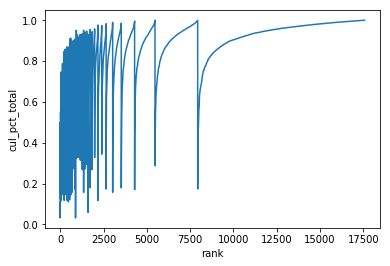

In [135]:
#Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc)

In [136]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.5013822554671907

In [137]:
#Analyze Tokens
nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [138]:
#Stop Words
STOP_WORDS = nlp.Defaults.stop_words.union(['finish', 'finish.', 'like', "it's", " ' ",])

In [139]:
#Tokenizer
tokens = []

for doc in tokenizer.pipe(train['description'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
train['tokens'] = tokens

In [140]:
wc = count_tokens(train['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
20,notes,765,883,1.0,0.007957,0.023484,0.295824
245,sweet,737,852,2.0,0.007678,0.205724,0.284996
244,oak,622,757,3.0,0.006822,0.198046,0.240526
150,whisky,504,660,4.0,0.005948,0.121953,0.194896
45,palate,601,611,5.0,0.005506,0.066316,0.232405


In [141]:
#Lemmatize
def train_lemmas(text):
    lemmas = []
    
    doc = nlp(text)
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas

In [142]:
train['lemmas'] = train['description'].apply(train_lemmas) 

In [143]:
train['lemmas'].head()

0    [marriage, 13, 18, year, old, bourbon, mature,...
1    [legendary, bowmore, mid-60, bit, equal, share...
2    [bottling, celebrate, master, distiller, parke...
3    [impress, whisky, evolve, incredibly, complex,...
4    [caramel, laden, fruit, bouquet, follow, unend...
Name: lemmas, dtype: object

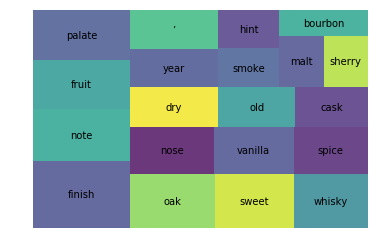

In [151]:
wc = count_tokens(train['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8)
plt.axis('off')
plt.show;
plt.savefig('lemmad.png', dpi=300)

AttributeError: 'DataFrame' object has no attribute 'data'

In [ ]:
#TFIDF

In [ ]:
#SKLEARN Pipeline/Components

In [ ]:
#LSI

In [ ]:
#Spacy Word Embeddings

In [ ]:
#Accuracy Score

In [ ]:
#Submission